In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img
# Mount Google Drive
drive.mount('/content/drive')

# Dataset Directories
train_dir = "/content/drive/MyDrive/dataset/DataFix/train"
test_dir = "/content/drive/MyDrive/dataset/DataFix/test"
tumor_classes = np.array(['glioma', 'meningioma', 'pituitary'])

# Display dataset structure
print(f"Training data directory: {train_dir}")
print(f"Testing data directory: {test_dir}")
print(f"Tumor classes: {tumor_classes}")

for tumor_class in tumor_classes:
    train_class_dir = os.path.join(train_dir, tumor_class)
    test_class_dir = os.path.join(test_dir, tumor_class)

    if os.path.exists(train_class_dir) and os.path.exists(test_class_dir):
        train_count = len(os.listdir(train_class_dir))
        test_count = len(os.listdir(test_class_dir))
        print(f"Class '{tumor_class}': {train_count} training images, {test_count} testing images")
    else:
        print(f"Warning: Directory for class '{tumor_class}' not found!")

print("Data loading complete!")

Mounted at /content/drive
Training data directory: /content/drive/MyDrive/dataset/DataFix/train
Testing data directory: /content/drive/MyDrive/dataset/DataFix/test
Tumor classes: ['glioma' 'meningioma' 'pituitary']
Class 'glioma': 1140 training images, 286 testing images
Class 'meningioma': 566 training images, 142 testing images
Class 'pituitary': 744 training images, 186 testing images
Data loading complete!


Found 1961 images belonging to 3 classes.
Found 489 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


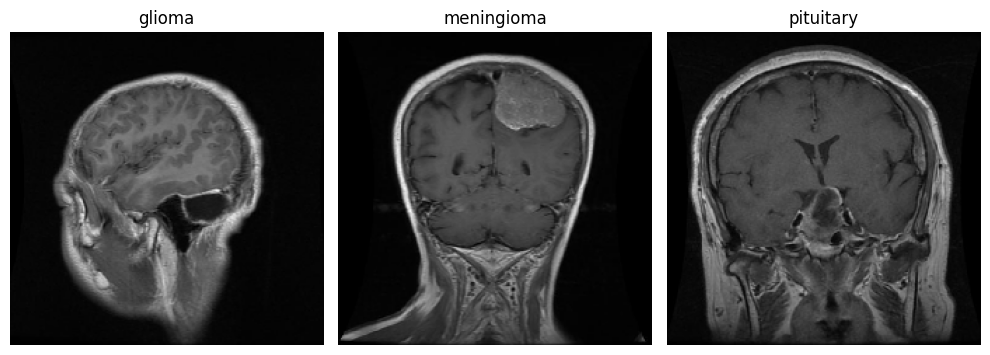

In [ ]:
# Preprocessing dan augmentasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Generator untuk training dan validasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk data pengujian
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
# Display sample images from training data
plt.figure(figsize=(10, 5))
for i, tumor_class in enumerate(tumor_classes):
    class_path = os.path.join(train_dir, tumor_class)
    if os.path.exists(class_path) and os.listdir(class_path):
        random_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image)
        original_img = load_img(image_path, target_size=(224, 224))

        plt.subplot(1, len(tumor_classes), i + 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(tumor_class)
plt.tight_layout()
plt.show()

In [ ]:
# Fungsi membuat model CNN VGG16
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Membekukan semua layer VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan lapisan klasifikasi di atas VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Gabungkan menjadi model akhir
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membuat dan kompilasi model
model = create_vgg16_model(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 670s 11s/step - accuracy: 0.4158 - loss: 1.0921 - val_accuracy: 0.5583 - val_loss: 0.9442 - learning_rate: 1.0000e-04
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 669ms/step - accuracy: 0.4809 - loss: 1.0332 - val_accuracy: 0.5399 - val_loss: 0.8735 - learning_rate: 1.0000e-04
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.5748 - loss: 0.9402 - val_accuracy: 0.6237 - val_loss: 0.8044 - learning_rate: 1.0000e-04
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 680ms/step - accuracy: 0.6282 - loss: 0.8642 - val_accuracy: 0.6299 - val_loss: 0.7762 - learning_rate: 1.0000e-04
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 666ms/step - accuracy: 0.6206 - loss: 0.8433 - val_accuracy: 0.6217 - val_loss: 0.7462 - learning_rate: 1.0000e-04
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 664ms/step - accuracy: 0.6576 - loss: 0.7909 - val_accuracy: 0.6626 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 709ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


614/614 ━━━━━━━━━━━━━━━━━━━━ 214s 346ms/step
Final Test Accuracy: 0.7980

Classification Report:
               precision    recall  f1-score   support

      glioma       0.79      0.87      0.83       286
  meningioma       0.71      0.51      0.59       142
   pituitary       0.86      0.90      0.88       186

    accuracy                           0.80       614
   macro avg       0.78      0.76      0.77       614
weighted avg       0.79      0.80      0.79       614



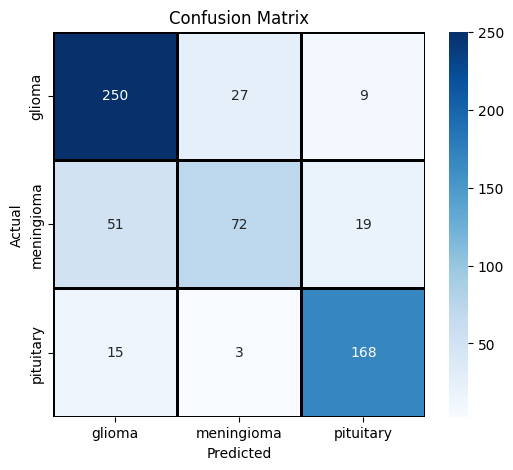

In [ ]:
import seaborn as sns
# Evaluate Model on Test Data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Metrics
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Final Test Accuracy: {accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=tumor_classes))

# Confusion Matrix with Seaborn
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=tumor_classes, yticklabels=tumor_classes, linewidths=1, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()